# S&P 500 Return Distribution Analysis

This notebook retrieves historical data for S&P 500 companies, calculates daily log returns, and analyzes their distribution compared to a normal distribution to identify fat tails and skewness.

In [3]:
import yfinance as yf
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import scipy.stats as stats
from concurrent.futures import ThreadPoolExecutor

# Set plotting style
plt.style.use('ggplot')

In [4]:
# --- PARAMETERS ---
START_DATE = "2023-01-01"
END_DATE = "2024-01-01"

## 1. Identify S&P 500 Tickers
Scraping the list of current S&P 500 companies from Wikipedia.

In [7]:
def get_sp500_tickers():
    url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
    headers = {
        "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0 Safari/537.36"
    }
    resp = requests.get(url, headers=headers)
    resp.raise_for_status()
    
    tables = pd.read_html(resp.text)
    df = tables[1]
    
    # Clean tickers: replace dots with dashes (e.g., BRK.B -> BRK-B) for yfinance compatibility
    tickers = df['Symbol'].str.replace('.', '-', regex=False).tolist()
    return tickers

tickers = get_sp500_tickers()
print(f"Found {len(tickers)} tickers.")

Found 503 tickers.


/var/folders/2j/32vzs7jx4mg8xc81v2qsjdmc0000gn/T/ipykernel_47715/1013245681.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  tables = pd.read_html(resp.text)


## 2. Retrieve Data & Calculate Returns (Parallelized)
Fetching daily data for all tickers and calculating daily log returns.

In [10]:
def get_stock_returns(ticker):
    try:
        # Fetch history
        df = yf.Ticker(ticker).history(start=START_DATE, end=END_DATE, auto_adjust=True)
        
        if df.empty or len(df) < 2:
            return None
        
        # Calculate daily log returns: ln(P_t / P_{t-1})
        # Log returns are additive and often preferred for distribution analysis
        df['Return'] = np.log(df['Close'] / df['Close'].shift(1))
        
        # Drop the first NaN created by shifting
        return df['Return'].dropna()
        
    except Exception as e:
        return None

# Use ThreadPoolExecutor for parallel downloads
all_returns = []
with ThreadPoolExecutor(max_workers=20) as executor:
    results = executor.map(get_stock_returns, tickers)
    
    for res in results:
        if res is not None:
            all_returns.append(res)

# Concatenate all series into one massive series of daily returns across all stocks
if all_returns:
    pooled_returns = pd.concat(all_returns)
    print(f"Total return data points: {len(pooled_returns)}")
else:
    print("No data retrieved.")

$GEV: possibly delisted; no price data found  (1d 2023-01-01 -> 2024-01-01) (Yahoo error = "Data doesn't exist for startDate = 1672549200, endDate = 1704085200")
$Q: possibly delisted; no price data found  (1d 2023-01-01 -> 2024-01-01) (Yahoo error = "Data doesn't exist for startDate = 1672549200, endDate = 1704085200")
$SNDK: possibly delisted; no price data found  (1d 2023-01-01 -> 2024-01-01) (Yahoo error = "Data doesn't exist for startDate = 1672549200, endDate = 1704085200")
$SOLS: possibly delisted; no price data found  (1d 2023-01-01 -> 2024-01-01) (Yahoo error = "Data doesn't exist for startDate = 1672549200, endDate = 1704085200")
$SOLV: possibly delisted; no price data found  (1d 2023-01-01 -> 2024-01-01) (Yahoo error = "Data doesn't exist for startDate = 1672549200, endDate = 1704085200")


Total return data points: 123729


## 3. Distribution Analysis
Plotting the histogram of returns and overlaying a Normal Distribution curve.

<>:27: SyntaxWarning: "\m" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\m"? A raw string is also an option.
<>:27: SyntaxWarning: "\s" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\s"? A raw string is also an option.
<>:27: SyntaxWarning: "\m" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\m"? A raw string is also an option.
<>:27: SyntaxWarning: "\s" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\s"? A raw string is also an option.
/var/folders/2j/32vzs7jx4mg8xc81v2qsjdmc0000gn/T/ipykernel_47715/87910105.py:27: SyntaxWarning: "\m" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\m"? A raw string is also an option.
  plt.plot(x, p, 'r', linewidth=2, label=f'Normal Dist ($\mu$={mu:.4f}, $\sigma$={std:.4f})')
/var/folders/2j/32vzs7jx4mg8xc81v2qsjdmc0000gn/T/ipykernel_477

Mean: 0.000655
Std Dev: 0.018352
Skewness: -0.2954 (Normal = 0)
Kurtosis: 18.6952 (Normal = 0, >0 indicates fat tails)


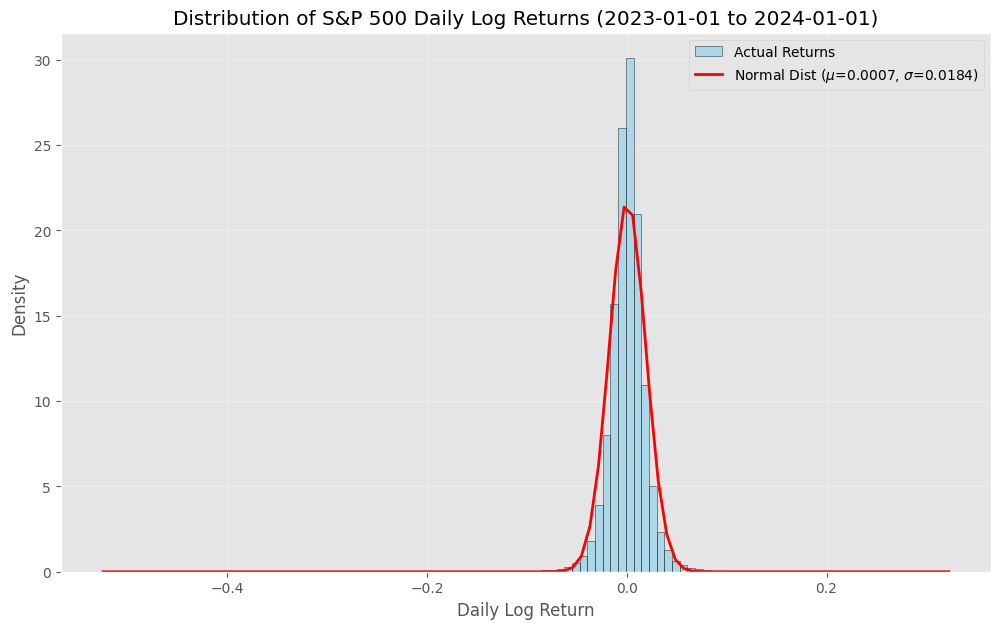

In [11]:
if all_returns:
    # Remove any infinite values just in case
    data = pooled_returns.replace([np.inf, -np.inf], np.nan).dropna()

    # --- Statistics ---
    mu, std = stats.norm.fit(data)
    skewness = data.skew()
    kurtosis = data.kurtosis()  # Excess kurtosis (Fisher's definition, normal = 0)

    print(f"Mean: {mu:.6f}")
    print(f"Std Dev: {std:.6f}")
    print(f"Skewness: {skewness:.4f} (Normal = 0)")
    print(f"Kurtosis: {kurtosis:.4f} (Normal = 0, >0 indicates fat tails)")

    # --- Visualization ---
    plt.figure(figsize=(12, 7))

    # 1. Histogram of actual data
    # Bins: 'auto' or a fixed high number to see detail
    # density=True ensures the area under the histogram sums to 1, matching the PDF
    plt.hist(data, bins=100, density=True, alpha=0.6, color='skyblue', label='Actual Returns', edgecolor='black', linewidth=0.5)

    # 2. Normal Distribution Curve
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = stats.norm.pdf(x, mu, std)
    plt.plot(x, p, 'r', linewidth=2, label=f'Normal Dist ($\mu$={mu:.4f}, $\sigma$={std:.4f})')

    plt.title(f'Distribution of S&P 500 Daily Log Returns ({START_DATE} to {END_DATE})')
    plt.xlabel('Daily Log Return')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Zoom in to the center to see the peak better, or keep full range to see tails
    # plt.xlim(-0.1, 0.1) 

    plt.show()
else:
    print("No data to analyze.")

## 4. Price Distribution Analysis (Log-Normality Check)
Testing if stock prices follow a Log-Normal distribution by analyzing the distribution of log(prices).

In [ ]:
# Fetch latest prices for all tickers
price_data = yf.download(tickers, period="1d", auto_adjust=True, group_by="ticker", progress=False)

# Extract closing prices (last available)
prices = []
for ticker in tickers:
    try:
        if ticker in price_data.columns.get_level_values(0):
            close_price = price_data[ticker]["Close"].iloc[-1]
            if not pd.isna(close_price) and close_price > 0:
                prices.append(close_price)
    except:
        pass

prices = pd.Series(prices)
print(f"Collected {len(prices)} valid prices.")

In [ ]:
if len(prices) > 0:
    log_prices = np.log(prices)
    
    # Statistics for log-prices
    mu_log, std_log = stats.norm.fit(log_prices)
    skew_log = log_prices.skew()
    kurt_log = log_prices.kurtosis()
    
    print(f"Log-Price Mean: {mu_log:.4f}")
    print(f"Log-Price Std Dev: {std_log:.4f}")
    print(f"Log-Price Skewness: {skew_log:.4f} (Normal = 0)")
    print(f"Log-Price Kurtosis: {kurt_log:.4f} (Normal = 0)")
    
    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot 1: Raw Prices
    ax1.hist(prices, bins=50, density=True, alpha=0.6, color="coral", edgecolor="black", linewidth=0.5)
    ax1.set_title("Distribution of Stock Prices (Raw)")
    ax1.set_xlabel("Price ($)")
    ax1.set_ylabel("Density")
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Log Prices with Normal overlay
    ax2.hist(log_prices, bins=50, density=True, alpha=0.6, color="lightgreen", label="Log(Price)", edgecolor="black", linewidth=0.5)
    xmin, xmax = ax2.get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = stats.norm.pdf(x, mu_log, std_log)
    ax2.plot(x, p, "r", linewidth=2, label=f"Normal Fit (μ={mu_log:.2f}, σ={std_log:.2f})")
    ax2.set_title("Distribution of Log(Prices)")
    ax2.set_xlabel("Log(Price)")
    ax2.set_ylabel("Density")
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("No price data available.")

## 5. Market Cap Distribution Analysis
Retrieving and analyzing the Market Capitalization of S&P 500 companies.

In [ ]:
def get_market_cap(ticker):
    try:
        # yf.Ticker(ticker).info is a separate API call per ticker
        info = yf.Ticker(ticker).info
        return info.get("marketCap")
    except:
        return None

print("Fetching market caps (this may take a moment)... ")
market_caps = []

# Use ThreadPoolExecutor for parallel requests
with ThreadPoolExecutor(max_workers=20) as executor:
    results = executor.map(get_market_cap, tickers)
    
    for res in results:
        if res is not None:
            market_caps.append(res)

# Convert to Billions for readability
mcaps_billions = pd.Series(market_caps) / 1e9
print(f"Collected {len(mcaps_billions)} market caps.")

In [ ]:
if not mcaps_billions.empty:
    # Statistics
    mean_mc = mcaps_billions.mean()
    median_mc = mcaps_billions.median()
    max_mc = mcaps_billions.max()
    min_mc = mcaps_billions.min()
    
    print(f"Mean Market Cap: ${mean_mc:.2f} B")
    print(f"Median Market Cap: ${median_mc:.2f} B")
    print(f"Max Market Cap: ${max_mc:.2f} B")
    print(f"Min Market Cap: ${min_mc:.2f} B")
    
    # Visualization
    plt.figure(figsize=(10, 6))
    plt.hist(mcaps_billions, bins=50, color="purple", alpha=0.7, edgecolor="black", linewidth=0.5)
    plt.title("Distribution of S&P 500 Market Capitalization")
    plt.xlabel("Market Cap ($ Billions)")
    plt.ylabel("Count")
    plt.grid(True, alpha=0.3)
    
    # Add vertical lines for Mean and Median
    plt.axvline(mean_mc, color="red", linestyle="dashed", linewidth=1, label=f"Mean: ${mean_mc:.0f}B")
    plt.axvline(median_mc, color="yellow", linestyle="dashed", linewidth=1, label=f"Median: ${median_mc:.0f}B")
    plt.legend()
    
    plt.show()
else:
    print("No market cap data available.")